# Pokemon Egg Groups using Networkx
In the Pokemon roleplaying game, a player can create offspring from their monsters by pairing them up. The player can pair the same species together, or pair similar Pokemon based on their Egg Group. The Egg Group is a category that a monster belongs to that denotes that it can breed with other monsters in that egg group. 

## Egg Group Network
Because each monster belongs to one or two egg groups, we can treat an inidividual monster as a node (or vertex) and pokemon that they can breed with as an edge. With this we can build an Egg Group network, connecting each monster to other monsters it can breed with or a graph of monsters in one egg group.

In [1]:
# import libraries
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# import dataset
pokedex_df = pd.read_csv("pokedex.csv")

### Data Cleanup
Now that we have our data set we can do some cleaning and replacement of missing values. We're using the same data file as a previous project so I will not go into depth. You can find that project here: https://nbviewer.org/github/Duelly-Baxter/My-notebooks/blob/main/Pokemon%20Stats%20Visualized.ipynb

In [2]:
# check for missing values
print("\n Missing Values by Column: ")
print(pokedex_df.isnull().sum())


 Missing Values by Column: 
index                 0
pokedex_number        0
name                  0
generation            0
status                0
fully_evolved         0
species               0
type_number           0
type_1                0
type_2              483
height_m              0
weight_kg             0
abilities_number      0
ability_1             0
ability_2           511
ability_hidden      216
total_points          0
hp                    0
attack                0
defense               0
sp_attack             0
sp_defense            0
speed                 0
growth_rate           1
egg_type_number       0
egg_type_1            1
egg_type_2          738
mega                  0
dtype: int64


In [3]:
# replace missing egg group
missing_egg_type_1 = pd.isnull(pokedex_df['egg_type_1'])
pokedex_df[missing_egg_type_1]
pokedex_df['egg_type_1'][650] = 'Field' # set darmanitan egg type

### Cut some monsters
For the sake of the size of this dataset and graphs we plan on to generate from it, we'll cut the dataset to include only fully evolved pokemon. These are pokemon that are in their final stage of growth. Because each pokemon shares the same egg group with its evolutions, we'll be missing nothing while saving on space. We can also remove all "Mega" pokemon. While these are often treated as discrete pokemon, they are temporary power boosts to a normal monster. Removing them will also not affect our results while saving on space.

In [4]:
pokedex_df = pokedex_df.query("fully_evolved == 1") # use .query() to filter fully_evolved pokemon
print(pokedex_df.head()) # print the head

   index  pokedex_number              name  generation  status  fully_evolved  \
2      2               3          Venusaur           1  Normal              1   
3      3               3     Mega Venusaur           1  Normal              1   
6      6               6         Charizard           1  Normal              1   
7      7               6  Mega Charizard X           1  Normal              1   
8      8               6  Mega Charizard Y           1  Normal              1   

         species  type_number type_1  type_2  ...  attack  defense  sp_attack  \
2   Seed Pokémon            2  Grass  Poison  ...      82       83        100   
3   Seed Pokémon            2  Grass  Poison  ...     100      123        122   
6  Flame Pokémon            2   Fire  Flying  ...      84       78        109   
7  Flame Pokémon            2   Fire  Dragon  ...     130      111        130   
8  Flame Pokémon            2   Fire  Flying  ...     104       78        159   

  sp_defense speed  growth

In [5]:
pokedex_df = pokedex_df.query("mega != 1") # use .query() to filter out mega pokemon
print(pokedex_df.head())

    index  pokedex_number        name  generation  status  fully_evolved  \
2       2               3    Venusaur           1  Normal              1   
6       6               6   Charizard           1  Normal              1   
11     11               9   Blastoise           1  Normal              1   
15     15              12  Butterfree           1  Normal              1   
18     18              15    Beedrill           1  Normal              1   

               species  type_number type_1  type_2  ...  attack  defense  \
2         Seed Pokémon            2  Grass  Poison  ...      82       83   
6        Flame Pokémon            2   Fire  Flying  ...      84       78   
11   Shellfish Pokémon            1  Water     NaN  ...      83      100   
15   Butterfly Pokémon            2    Bug  Flying  ...      45       50   
18  Poison Bee Pokémon            2    Bug  Poison  ...      90       40   

    sp_attack sp_defense speed  growth_rate  egg_type_number  egg_type_1  \
2         

### Exploring the Egg Groups
With the head of our new dataframe printed, you may have noticed that some pokemon have two egg groups. This is something we'll tackle later. For now, let's plot how many of each egg group we have. 

In [6]:
temp_df1 = pokedex_df['egg_type_1'] # add type 1 to a temp df
temp_df2 = pokedex_df['egg_type_2'] # add type 2 to a temp df

pokemon_egg_df = pd.concat([temp_df1, temp_df2]) # concatenate our temp dfs to a new df

# use value_counts() to create a new dict with our counts for each egg group. we convert to a series because it's nicer
print(pd.Series(pokemon_egg_df).value_counts())

Field           143
Undiscovered    105
Water 1          59
Bug              40
Mineral          39
Amorphous        39
Monster          38
Grass            37
Fairy            37
Human-Like       37
Flying           36
Dragon           32
Water 3          18
Water 2          18
Ditto             1
dtype: int64


It looks like the Field group is the largest by a wide margin! Two things to consider with the Undiscovered and Ditto groups. The Undiscovered egg group is sterile - monsters that belong to it belong only to it and cannot reproduce in any way. Unlike the Undiscovered group, the Ditto egg group contains only one pokemon, Ditto, and can breed with every other pokemon. For the sake of this network, we'll remove Undiscovered but handle Ditto later. 

In [7]:
# We'll remove undiscovered by using .query a second time
pokedex_df = pokedex_df.query("egg_type_1 != 'Undiscovered'")
print(pokedex_df.head())

    index  pokedex_number        name  generation  status  fully_evolved  \
2       2               3    Venusaur           1  Normal              1   
6       6               6   Charizard           1  Normal              1   
11     11               9   Blastoise           1  Normal              1   
15     15              12  Butterfree           1  Normal              1   
18     18              15    Beedrill           1  Normal              1   

               species  type_number type_1  type_2  ...  attack  defense  \
2         Seed Pokémon            2  Grass  Poison  ...      82       83   
6        Flame Pokémon            2   Fire  Flying  ...      84       78   
11   Shellfish Pokémon            1  Water     NaN  ...      83      100   
15   Butterfly Pokémon            2    Bug  Flying  ...      45       50   
18  Poison Bee Pokémon            2    Bug  Poison  ...      90       40   

    sp_attack sp_defense speed  growth_rate  egg_type_number  egg_type_1  \
2         

## Make the Network Graph
The way we will make the network is by using the Network X library, which we have previously imported. More about Network X can be learned at networkx.org. For this problem, we are going to copy the original pokedex_df into a temporary dataframe but only include the index, name, and egg groups. Next we will use dict comprehnsion to create a dictionary of dictionary of the form {name : {egg_type_1: egg group, egg_type_2: egg group}}. We are putting our data in this form to play nicely with the networkx library and (hopefully) expedite our graph. We will use the library's functions to create nodes from the monster names that contain attributes in the form of a key: value pair. 

Next, we will create the edges by leveraging each nodes attributes that store the egg type values.

In [8]:
temp_df = pokedex_df[['index','name','egg_type_1','egg_type_2']].copy()
node_dict = temp_df.set_index('name').groupby(level='name').apply(lambda x: x.set_index('index').squeeze().to_dict()).to_dict()
node_dict

{'Abomasnow': {'egg_type_1': 'Grass', 'egg_type_2': 'Monster'},
 'Absol': {'egg_type_1': 'Field', 'egg_type_2': nan},
 'Accelgor': {'egg_type_1': 'Bug', 'egg_type_2': nan},
 'Aegislash Blade Forme': {'egg_type_1': 'Mineral', 'egg_type_2': nan},
 'Aegislash Shield Forme': {'egg_type_1': 'Mineral', 'egg_type_2': nan},
 'Aerodactyl': {'egg_type_1': 'Flying', 'egg_type_2': nan},
 'Aggron': {'egg_type_1': 'Monster', 'egg_type_2': nan},
 'Alakazam': {'egg_type_1': 'Human-Like', 'egg_type_2': nan},
 'Alcremie': {'egg_type_1': 'Amorphous', 'egg_type_2': 'Fairy'},
 'Alolan Dugtrio': {'egg_type_1': 'Field', 'egg_type_2': nan},
 'Alolan Exeggutor': {'egg_type_1': 'Grass', 'egg_type_2': nan},
 'Alolan Golem': {'egg_type_1': 'Mineral', 'egg_type_2': nan},
 'Alolan Marowak': {'egg_type_1': 'Monster', 'egg_type_2': nan},
 'Alolan Ninetales': {'egg_type_1': 'Field', 'egg_type_2': nan},
 'Alolan Persian': {'egg_type_1': 'Field', 'egg_type_2': nan},
 'Alolan Raichu': {'egg_type_1': 'Fairy', 'egg_type_2'

### Making the Graph
Now that we have sored our data in a dcitionary, we'll create the graph and plot our nodes. Using the above method you could also store other values of monsters such as typing. 

Once we have the nodes plotted, we will then create the edges of the graphs by creating an edge between nodes that share an egg type attribute.

In [9]:
# create the graph and name it simply G
G = nx.Graph() 
# add the nodes from our nodes dictionary
G.add_nodes_from(node_dict) 
# now set the attributes of each node. This part is really why we went through
# the trouble of creating our dictionary of dictionaries in node_dict
nx.set_node_attributes(G, node_dict) 


# now just checking if we did it correctly. Yup!
G.nodes.data()

NodeDataView({'Abomasnow': {'egg_type_1': 'Grass', 'egg_type_2': 'Monster'}, 'Absol': {'egg_type_1': 'Field', 'egg_type_2': nan}, 'Accelgor': {'egg_type_1': 'Bug', 'egg_type_2': nan}, 'Aegislash Blade Forme': {'egg_type_1': 'Mineral', 'egg_type_2': nan}, 'Aegislash Shield Forme': {'egg_type_1': 'Mineral', 'egg_type_2': nan}, 'Aerodactyl': {'egg_type_1': 'Flying', 'egg_type_2': nan}, 'Aggron': {'egg_type_1': 'Monster', 'egg_type_2': nan}, 'Alakazam': {'egg_type_1': 'Human-Like', 'egg_type_2': nan}, 'Alcremie': {'egg_type_1': 'Amorphous', 'egg_type_2': 'Fairy'}, 'Alolan Dugtrio': {'egg_type_1': 'Field', 'egg_type_2': nan}, 'Alolan Exeggutor': {'egg_type_1': 'Grass', 'egg_type_2': nan}, 'Alolan Golem': {'egg_type_1': 'Mineral', 'egg_type_2': nan}, 'Alolan Marowak': {'egg_type_1': 'Monster', 'egg_type_2': nan}, 'Alolan Ninetales': {'egg_type_1': 'Field', 'egg_type_2': nan}, 'Alolan Persian': {'egg_type_1': 'Field', 'egg_type_2': nan}, 'Alolan Raichu': {'egg_type_1': 'Fairy', 'egg_type_2': 

In [10]:
# compare each egg_type attribute to the others and create an edge between
# the nodes if the attributes match
for start in G.nodes(data=True):
    for end in G.nodes(data=True):
        for attr in list(start[1].keys()):
            if start[1]['egg_type_1'] == end[1]['egg_type_1']:
                G.add_edge(start[0], end[0])
            if start[1]['egg_type_2'] == end[1]['egg_type_2']:
                G.add_edge(start[0], end[0])
            if start[1]['egg_type_1'] == end[1]['egg_type_2']:
                G.add_edge(start[0], end[0])

G.edges.data()
# You'll notice the monsters have an edge back to itself. Which monsters can
# of course reproduce within their own species, so it fits. 

EdgeDataView([('Abomasnow', 'Abomasnow', {}), ('Abomasnow', 'Alolan Exeggutor', {}), ('Abomasnow', 'Amoonguss', {}), ('Abomasnow', 'Ampharos', {}), ('Abomasnow', 'Appletun', {}), ('Abomasnow', 'Avalugg', {}), ('Abomasnow', 'Bellossom', {}), ('Abomasnow', 'Breloom', {}), ('Abomasnow', 'Cacturne', {}), ('Abomasnow', 'Carnivine', {}), ('Abomasnow', 'Charizard', {}), ('Abomasnow', 'Cherrim', {}), ('Abomasnow', 'Comfey', {}), ('Abomasnow', 'Drampa', {}), ('Abomasnow', 'Druddigon', {}), ('Abomasnow', 'Eldegoss', {}), ('Abomasnow', 'Exeggutor', {}), ('Abomasnow', 'Exploud', {}), ('Abomasnow', 'Ferrothorn', {}), ('Abomasnow', 'Flapple', {}), ('Abomasnow', 'Garchomp', {}), ('Abomasnow', 'Haxorus', {}), ('Abomasnow', 'Heliolisk', {}), ('Abomasnow', 'Helioptile', {}), ('Abomasnow', 'Hoppip', {}), ('Abomasnow', 'Jumpluff', {}), ('Abomasnow', 'Lilligant', {}), ('Abomasnow', 'Ludicolo', {}), ('Abomasnow', 'Lurantis', {}), ('Abomasnow', 'Maractus', {}), ('Abomasnow', 'Meganium', {}), ('Abomasnow', 'N

Now this is a large amount of edges and vertices! It would be cumbersome to display them ALL at once in this form. So let's choose one egg group and display its egg web.

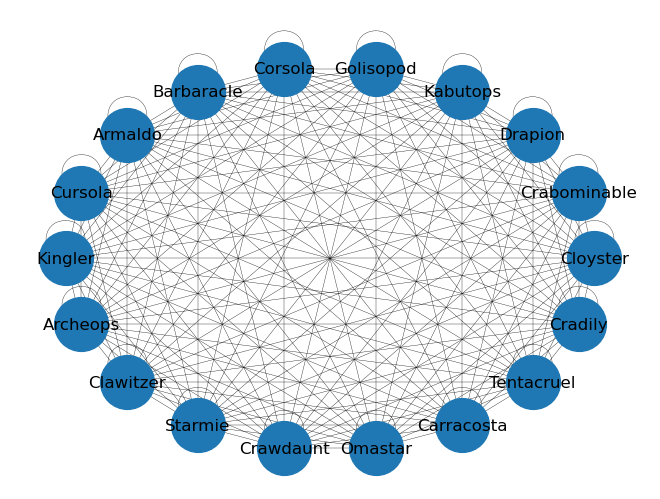

In [11]:
water3_lst = [x for x,y in G.nodes(data=True) if y['egg_type_1']=='Water 3' or y['egg_type_2']=='Water 3']
water3_G = G.subgraph(water3_lst)
nx.draw_shell(water3_G, with_labels=True,
              node_size=1500,
              width=0.25,
             )

## Conclusion
And there you have it! A short demonstration of networkx and a network visualizaiton using the pokemon dataset. From here we could spin the foundation here into a lot more functions, such as creating an egg move graph. Alas, that is for another project and we will end this one here. 